In [1]:
# 기본 setting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import warnings
warnings.filterwarnings(action = 'ignore')
pd.options.display.float_format = '{:.5f}'.format

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import plot_importance
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Dropout
from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import KFold , GridSearchCV , train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve,confusion_matrix
from sklearn.preprocessing import Binarizer

# 1. 모델 돌리기 전 함수 만들기
## 1-1) train,test 나누는 함수

In [4]:
df = pd.read_csv('./data/df_over.csv', index_col=0)

In [ ]:
# 1) train, test 나누는 함수
def data(df):
    X = df.drop(['y'], axis=1)
    y = df[['y']]
    col = X.drop(['회계년도'],axis=1)

    # 2018년까지 X_train / 2019,2020년 y_train
    X_train = X[X['회계년도']<2019].drop('회계년도',axis=1)
    X_test = X[X['회계년도']>2018].drop('회계년도',axis=1)
    y_train = y.iloc[X_train.index]
    y_test = y.iloc[X_test.index]

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=col.columns)

    return X_train, X_test, y_train, y_test

## 1-2) confusion matrix 만드는 함수 만들기

In [6]:
# 2) confusion matrix 만드는 함수
def score(y_test, pred):
    # score print
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    # confusion matirx 함수
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [7]:
# 3) thresholds를 무엇으로 하는가에 따라 score 산출하는 함수
def get_f1_score(y_test, pred_proba_1):

    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
        
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

# 1. Logistic Regression

In [23]:
def Logistic(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()
    param_logit = {'penalty' : ['l2'],
                   'C' : [0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'], # 'lbfgs', 'newton-cg' 
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv = KFold(n_splits=5, shuffle = True, random_state=42), n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)


    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))
    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef
    return gridsearch.fit(X_train, y_train)

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8038870806721274

예측 데이터 정확도
accuracy score : 0.802
precision score : 0.824
recall score : 0.769
f1 score : 0.795
roc score : 0.802
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.69231    0.62681 0.95055   0.75546    0.69231
0.30000   0.76648    0.70815 0.90659   0.79518    0.76648
0.40000   0.79670    0.76733 0.85165   0.80729    0.79670
0.50000   0.80220    0.82353 0.76923   0.79545    0.80220
0.60000   0.78571    0.87143 0.67033   0.75776    0.78571
0.70000   0.75824    0.91964 0.56593   0.70068    0.75824
0.80000   0.69231    0.92683 0.41758   0.57576    0.69231
0.90000   0.60714    0.97561 0.21978   0.35874    0.60714
None


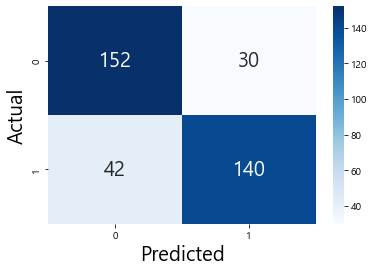

In [ ]:
logistic = Logistic(df)

# 2. DecisionTree

In [9]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['gini','entropy','log_loss'],   # 기본적으로 gini가 사용, 엔트로피 : 균형적인 트리
                    'splitter' : ['best', 'random'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 4, 5],
                    'class_weight' : ['balanced']}
    
    scaler = RobustScaler()
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv = KFold(n_splits=5, shuffle = True, random_state=42), n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    print('\n예측 데이터 정확도')
    score(y_test, pred)
    
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)


In [10]:
def DT_vis(df, best_model):
    export_graphviz(best_model.best_estimator_, out_file='트리확인후삭제.dot', class_names=["0", "1"], feature_names= df.drop(['y'], axis=1).columns, impurity=True, filled=True)

    with open('트리확인후삭제.dot', encoding='utf-8') as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

# 3. SVM

In [17]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC(probability=True)
    param_svc = {'C' : [0.01, 0.1, 1.0, 10.0],
                    'kernel' : [kernel],
                    'gamma' : [0.5, 0.1, 'scale'], # 1 / (n_features * X.var())
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=KFold(n_splits=5, shuffle = True, random_state=30), n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    return gridsearch.fit(X_train, y_train)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 0.5, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8166545452704591

예측 데이터 정확도
accuracy score : 0.797
precision score : 0.784
recall score : 0.819
f1 score : 0.801
roc score : 0.797


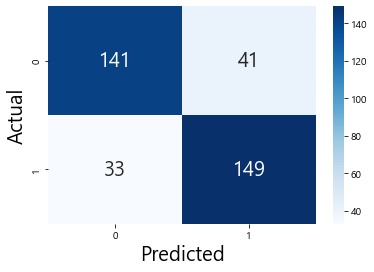

In [18]:
svm = SVM(df, 'rbf')

# 4. RandomForest

In [87]:
def RF(df):
    X_train, X_test, y_train, y_test = data(df)
    rf = RandomForestClassifier()
    
    params_rf = {
        'n_estimators':[400],
        'max_depth' : [4], 
        'min_samples_leaf' : [4, 6],
        'min_samples_split' : [ 12, 14, 16]
    }

    gridsearch = GridSearchCV(rf , param_grid=params_rf , cv=KFold(n_splits=5, shuffle = True, random_state=121), n_jobs=-1 )
    gridsearch.fit(X_train, y_train)
    warnings.filterwarnings('ignore')

    
    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    print('최적 하이퍼 파라미터:\n', gridsearch.best_params_)
    print('최고 예측 정확도: {0:.4f}'.format(gridsearch.best_score_))
    score(y_test, pred)
    
    # # feature_importance 보여주기
    ftr_importances_values = estimator.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

    plt.figure(figsize=(8,6))
    plt.title('Feature importances')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()


    return gridsearch.fit(X_train, y_train)

최적 하이퍼 파라미터:
 {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 400}
최고 예측 정확도: 0.8136
accuracy score : 0.799
precision score : 0.808
recall score : 0.786
f1 score : 0.797
roc score : 0.799


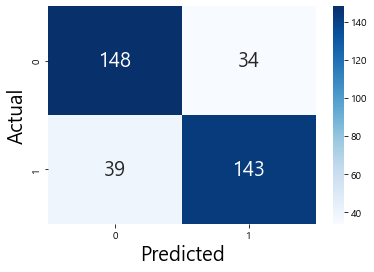

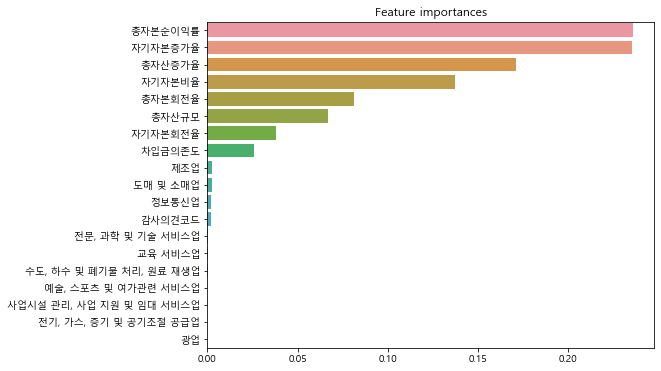

In [88]:
rf = RF(df)

# 5. LightGBM

In [89]:
def LGBM(df):
    import re
    X_train, X_test, y_train, y_test = data(df.rename(columns = lambda x:re.sub(',', '', x)))
    lgbm = LGBMClassifier()
    
    params = {
    'n_estimators':[200, 300, 400],
        'max_depth' : [4, 5, 6, 7, 8], 
    'min_data_in_leaf' : [8, 10, 12, 14, 16]
    }
    
    # 조기 중단 추가
    evals = [(X_train, y_train)]
    gridsearch = GridSearchCV(lgbm , param_grid=params , cv=KFold(n_splits=5, shuffle = True, random_state=42), n_jobs=-1 )
    gridsearch.fit(X_train , y_train,early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=0)


    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    print('최적 하이퍼 파라미터:\n', gridsearch.best_params_)
    print('최고 예측 정확도: {0:.4f}'.format(gridsearch.best_score_))
    score(y_test, pred)
    
    # feature_importance 보여주기
    ftr_importances_values = estimator.feature_importances_
    ftr_importances = pd.DataFrame({'Value':ftr_importances_values,'Feature':X_train.columns})

    plt.figure(figsize=(8,6))
    sns.barplot(x="Value", y="Feature", data=ftr_importances.sort_values(by="Value",ascending=False)[:20])
    plt.title('LightGBM Features')
    plt.show()
    return gridsearch.fit(X_train , y_train,early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=0)

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
최적 하이퍼 파라미터:
 {'max_depth': 7, 'min_data_in_leaf': 14, 'n_estimators': 200}
최고 예측 정확도: 0.8032
accuracy score : 0.783
precision score : 0.798
recall score : 0.758
f1 score : 0.777
roc score : 0.783


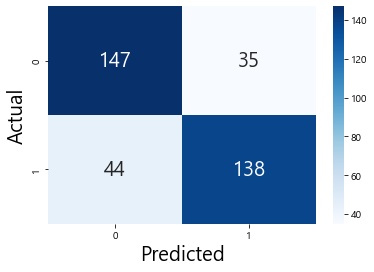

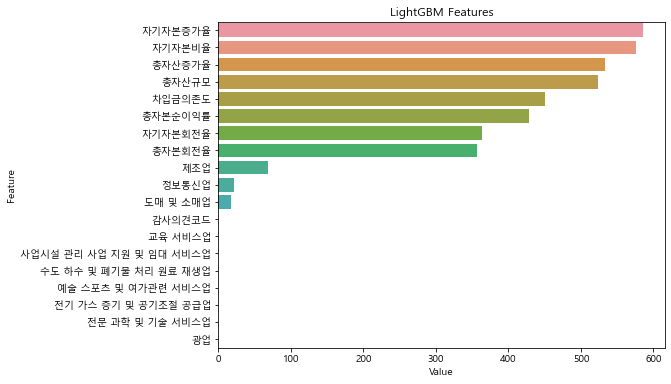

[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


In [90]:
lgbm = LGBM(df)

# 6. XGB

In [103]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'learning_rate' : [0.01],    # 나중에 한 번 더 확인
               'n_estimators' : [400],
               'min_child_weight' : [3],  ###
               'gamma' : [1.0],    ###
               'max_depth' : [5],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.8],
               'colsample_bylevel' : [0.6],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['y']==0])/len(df[df['y']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=KFold(n_splits=5, shuffle = True, random_state=42), n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    print('\n예측 데이터 정확도')
    score(y_test, pred)
    
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))
    return gridsearch.fit(X_train, y_train)

[20:38:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 1.0, 'silent': 1}
학습 데이터 정확도 :  0.8279990374832596

예측 데이터 정확도
accuracy score : 0.810
precision score : 0.830
recall score : 0.780
f1 score : 0.805
roc score : 0.810
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.72253    0.66135 0.91209   0.76674    0.72253
0.30000   0.78571    0.73853 0.88462   0.80500    0

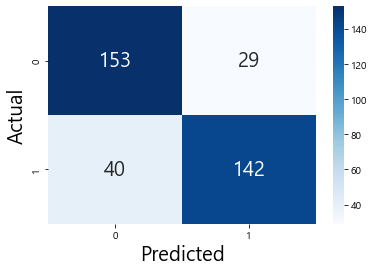

In [104]:
xgb = XGB(df)

# 7. Voting

In [35]:
def SV(df):
    import re
    X_train, X_test, y_train, y_test = data(df.rename(columns = lambda x:re.sub(',', '', x)))

    estimators = [['lr', logistic.best_estimator_],
                  ['rf', rf.best_estimator_],
                  ['dt', df_tree.best_estimator_],
                  ['svm', svm.best_estimator_],
                  ['lgbm',lgbm.best_estimator_],
                  ['xgb', xgb.best_estimator_]]  # 모델 집합
    
    SV = VotingClassifier(estimators, voting="soft",n_jobs=-1)
    SV.fit(X_train, y_train)
    pred = pd.DataFrame(SV.predict(X_test))
    
    print('\n예측 데이터 정확도')
    score(y_test, pred)
    
    pred_probability = pd.DataFrame(SV.predict_proba(X_test))
    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))
    return SV.fit(X_train, y_train)


예측 데이터 정확도
accuracy score : 0.810
precision score : 0.816
recall score : 0.802
f1 score : 0.809
roc score : 0.810
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.70604    0.64822 0.90110   0.75402    0.70604
0.30000   0.77198    0.72603 0.87363   0.79302    0.77198
0.40000   0.81319    0.79082 0.85165   0.82011    0.81319
0.50000   0.81044    0.81564 0.80220   0.80886    0.81044
0.60000   0.79121    0.84416 0.71429   0.77381    0.79121
0.70000   0.76099    0.85714 0.62637   0.72381    0.76099
0.80000   0.73077    0.91176 0.51099   0.65493    0.73077
0.90000   0.64560    0.96491 0.30220   0.46025    0.64560
None


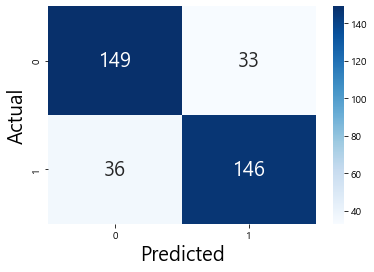

In [36]:
sv = SV(df)

# 8. Stacking Ensemble

In [94]:
# 개별모델 내부에서 CV 적용해 Stacking하는 함수 구현
def get_stacking_datasets(model,df,n_folds=5):

    import re
    X_train, X_test, y_train, y_test = data(df.rename(columns = lambda x:re.sub(',', '', x)))
    
    # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
    train_fold_pred = np.zeros((X_train.shape[0], 1)) # 2차원으로
    test_pred = np.zeros((X_test.shape[0], n_folds))
    print(model.__class__.__name__, '모델 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_folds, shuffle=True, random_state=42).split(X_train)):
        # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터 셋 추출
        print(f" Fold 횟수 : {folder_counter+1}")
        X_train_ = X_train.iloc[train_idx]
        y_train_ = y_train.iloc[train_idx]
        X_test_ = X_train.iloc[valid_idx]
        
        # 개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
        model.fit(X_train_, y_train_)
        train_fold_pred[valid_idx, :] = model.predict(X_test_).reshape(-1,1)
        # 개별 모델이 원본 데이터셋의 검증 데이터셋을 기반으로 예측 결과값 반환 후 최종 메타모델이 검증할 데이터셋에 첨가
        test_pred[:, folder_counter] = model.predict(X_test)
    
    # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸어주기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [95]:
def stacking(df):
    
    X_train, X_test, y_train, y_test = data(df)
    
    lo_train, lo_test = get_stacking_datasets(logistic.best_estimator_, df, 5)
    rf_train, rf_test = get_stacking_datasets(rf.best_estimator_, df, 5)
    dt_train, dt_test = get_stacking_datasets(df_tree.best_estimator_, df, 5)
    svm_train, svm_test = get_stacking_datasets(svm.best_estimator_, df, 5)
    xgb_train, xgb_test = get_stacking_datasets(xgb.best_estimator_, df, 5)
    
    new_X_train = np.concatenate((lo_train, rf_train, dt_train), axis = 1)
    new_X_test = np.concatenate((lo_test, rf_test,dt_test), axis = 1)
    
    # meta learner
    lgbm.best_estimator_.fit(new_X_train, y_train)
    y_test = pd.DataFrame(y_test)
    stack_pred = pd.DataFrame(lgbm.best_estimator_.predict(new_X_test))
    print('\n예측 데이터 정확도')
    score(y_test, stack_pred)

LogisticRegression 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
RandomForestClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
DecisionTreeClassifier 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
SVC 모델 시작
 Fold 횟수 : 1
 Fold 횟수 : 2
 Fold 횟수 : 3
 Fold 횟수 : 4
 Fold 횟수 : 5
XGBClassifier 모델 시작
 Fold 횟수 : 1
[20:33:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 Fold 횟수 : 2
[20:33:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with som

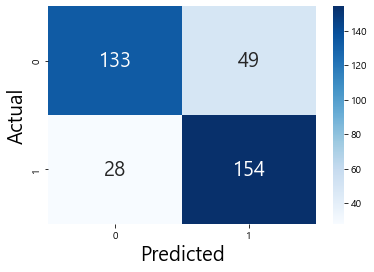

In [96]:
stacking(df)

# 9. DNN

In [105]:
#F1-score
from tensorflow.keras import backend as K
def custom_f1(y_target, y_pred):    
    def recall(y_target, y_pred):
    
        y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
        y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

        count_true_positive = K.sum(y_target_yn * y_pred_yn) 
        count_true_positive_false_negative = K.sum(y_target_yn)

        # Recall =  (True Positive) / (True Positive + False Negative)
        # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
        recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
        return recall


    def precision(y_target, y_pred):
    
        y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
        y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

        count_true_positive = K.sum(y_target_yn * y_pred_yn) 
        count_true_positive_false_positive = K.sum(y_pred_yn)

        # Precision = (True Positive) / (True Positive + False Positive)
        # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
        precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

        # return a single tensor value
        return precision

    precision, recall = precision(y_target, y_pred), recall(y_target, y_pred)

    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    return ( 2 * recall * precision) / (recall + precision+ K.epsilon())

In [106]:
def build_classifier(optimizer, n_units, n_layers):
    classifier = Sequential()
    classifier.add(Dense(units = n_units, kernel_initializer = 'uniform', activation = 'relu', input_dim = 19)) # kernel_initializer는 default값
    
    for i in range(n_layers):
        classifier.add(Dense(units = n_units, kernel_initializer = 'uniform', activation = 'relu'))
        
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = [custom_f1])
    return classifier

In [107]:
# DNN은 GridSearchcv 너무 오래걸리기 때문에 random search로 진행
from sklearn.model_selection import RandomizedSearchCV
def DNN(df):
    X_train, X_test, y_train, y_test = data(df)

    classifier = KerasClassifier(build_fn = build_classifier)
    parameters = {
        'batch_size': [10,20,40,80],
        'epochs': [100,200],
        'optimizer': ['adam', 'rmsprop'],
        'n_units': [10, 20, 30],
        'n_layers': [1,2,3]
    }
    
    random_search = RandomizedSearchCV(classifier, param_distributions=parameters, cv=KFold(n_splits=5, shuffle = True, random_state=42), scoring = 'f1', n_jobs=-1, verbose = 1)
    random_search = random_search.fit(X_train, y_train)
    # print('최적 파라미터\n', random_search.best_params_)
    # print('학습 데이터 정확도 : ', random_search.best_score_)
    
    estimator = random_search.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    
    print('\n예측 데이터 정확도')
    score(y_test, pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/100
29/29 [==============================] - 1s 781us/step - loss: 0.6932 - custom_f1: 0.4590
Epoch 2/100
29/29 [==============================] - 0s 663us/step - loss: 0.6930 - custom_f1: 0.6638
Epoch 3/100
29/29 [==============================] - 0s 749us/step - loss: 0.6907 - custom_f1: 0.7466
Epoch 4/100
29/29 [==============================] - 0s 783us/step - loss: 0.6820 - custom_f1: 0.7059
Epoch 5/100
29/29 [==============================] - 0s 840us/step - loss: 0.6612 - custom_f1: 0.7546
Epoch 6/100
29/29 [==============================] - 0s 881us/step - loss: 0.6271 - custom_f1: 0.7802
Epoch 7/100
29/29 [==============================] - 0s 832us/step - loss: 0.5892 - custom_f1: 0.7879
Epoch 8/100
29/29 [==============================] - 0s 931us/step - loss: 0.5639 - custom_f1: 0.8041
Epoch 9/100
29/29 [==============================] - 0s 791us/step - loss: 0.5504 - custom_f1: 0.7941
Epoch 10/100
29/29 [=

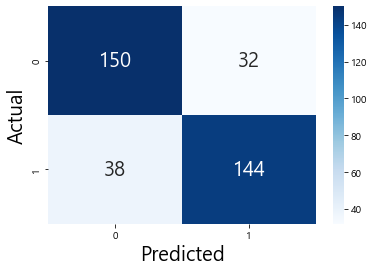

In [108]:
DNN(df)

## 10-2. over sampling결과에 raw데이터 넣기

In [111]:
df_raw = pd.read_csv('./data/df_final_raw.csv', index_col=0, encoding='utf-8')

X = df_raw.drop(['y','회사명','거래소코드','회계년도'], axis=1)
X = X[['자기자본비율', '총자산규모', '총자본회전율', '총자본순이익률', '자기자본증가율', '자기자본회전율', '차입금의존도',
       '총자산증가율','광업', '교육 서비스업', '감사의견코드',
       '도매 및 소매업', '사업시설 관리, 사업 지원 및 임대 서비스업', '수도, 하수 및 폐기물 처리, 원료 재생업',
       '예술, 스포츠 및 여가관련 서비스업', '전기, 가스, 증기 및 공기조절 공급업', '전문, 과학 및 기술 서비스업',
       '정보통신업', '제조업']]
y = df_raw[['y']]

In [112]:
print('\nsv')
sv_pred = sv.predict(X)

sv_pred


sv


array([0., 1., 0., ..., 1., 0., 1.])

In [113]:
# 1) 실제 df
df_raw_실제 = df_raw.drop(['자기자본비율', '총자산규모', '총자본회전율', '총자본순이익률', '자기자본증가율', '자기자본회전율', '차입금의존도',
       '총자산증가율','광업', '교육 서비스업', '감사의견코드','회사명',
       '도매 및 소매업', '사업시설 관리, 사업 지원 및 임대 서비스업', '수도, 하수 및 폐기물 처리, 원료 재생업',
       '예술, 스포츠 및 여가관련 서비스업', '전기, 가스, 증기 및 공기조절 공급업', '전문, 과학 및 기술 서비스업',
       '정보통신업', '제조업'], axis=1,)

In [116]:
# 2) 예측 df 합치기
예측 = pd.Series(sv_pred)
df_실제예측 = pd.concat([df_raw_실제, 예측], axis=1)
df_실제예측.rename(columns={0:'예측'},inplace=True)
df_실제예측

,거래소코드,회계년도,y,예측
0,58820,2011,0.00000,0.00000
1,58820,2012,0.00000,1.00000
2,58820,2013,0.00000,0.00000
3,58820,2014,0.00000,0.00000
4,58820,2015,0.00000,0.00000
...,...,...,...,...
10654,24060,2016,0.00000,0.00000
10655,24060,2017,0.00000,0.00000
10656,24060,2018,0.00000,1.00000
10657,24060,2019,0.00000,0.00000


In [117]:
df_실제예측.to_csv('./data/실제_예측.csv', encoding='utf-8-sig')